In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

In [3]:
df =  pd.read_parquet('logs.parquet')

# Reglas de asociación

## Filtrado y exploracion de los datos

Observación de cuantas piezas unicas hay en nuestro conjunto, descartando aquellas a las que pertenecen a un diseño no válido, y cuantas operaciones han habido.

In [4]:
añadir_pieza = df[(df['Evento'] == 'AÑADIR_PIEZA') & (df['diseñoid'] != -1) & (df['diseñoid'] != 0)].copy()
añadir_pieza = añadir_pieza[['pieza','diseñoid']]
print(f"Número total de transacciones: {añadir_pieza['diseñoid'].nunique()}")
print(f"Número total de ítems (productos): {añadir_pieza['pieza'].nunique()}")

Número total de transacciones: 1694
Número total de ítems (productos): 6981


## Observación del tamaño de las transacciones

count    1694.000000
mean       12.605667
std        15.135197
min         1.000000
25%         3.000000
50%         8.000000
75%        17.000000
90%        29.000000
max       213.000000
Name: pieza, dtype: float64

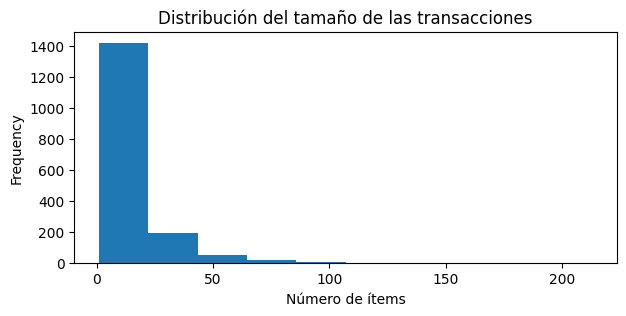

In [5]:
display(añadir_pieza.groupby('diseñoid')['pieza'].size().describe(percentiles=[.25, .5, .75, .9]))
fig, ax = plt.subplots(figsize=(7, 3))
añadir_pieza.groupby('diseñoid')['pieza'].size().plot.hist(ax=ax)
ax.set_title('Distribución del tamaño de las transacciones');
ax.set_xlabel('Número de ítems');

Podemos observar como la mayoría de los usuarios escogen entre 3 y 17 piezas, siendo una media de 12 piezas por diseño, además el 90% escogen menos de 29 piezas  

## Transformacion del dataframe en transacciones

In [6]:
transacciones = añadir_pieza.groupby('diseñoid')['pieza'].apply(list).to_list()
te = TransactionEncoder()
te_ary = te.fit(transacciones).transform(transacciones)
df_transacciones = pd.DataFrame(te_ary, columns=te.columns_)
df_transacciones.head(5)

,0070,030,0600,0600_G,0P120,100,1000,1001,1003,1004,...,Z-912,Z-922,ZK110,ZK120,ZK180,ZK75,ZN102,ZN140,ZN60,ZN74
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Aplicación del algoritmo apriori

Uso un soporte mínimio del 0.0025 para que me genere las suficientes reglas para poder trabajar con ellas.

In [7]:
itemsets = apriori(df_transacciones, min_support=0.00245, use_colnames=True)

Ordeno los itemsets por frecuencia de manera descendente

In [8]:

itemsets['n_items'] = itemsets['itemsets'].apply(len)
itemsets.sort_values(by='support', ascending=False)

,support,itemsets,n_items
256,0.111570,(EE-PILAR-01),1
266,0.094451,(EE-VCR-01),1
258,0.073790,(EE-RAD-01),1
384,0.072609,(SGE-001),1
154,0.060803,(ED-ALF-02),1
...,...,...,...
1554,0.002952,"(582, ED-ALF-02, 21, 578, MSPT, 903)",6
1542,0.002952,"(ED-ALF-02, ED-TVT-01, 578, MSPT, 903)",5
1543,0.002952,"(ED-ALF-02, SOF-022, ED-TVT-01, 578, 903)",5
1544,0.002952,"(ED-ALF-02, SOF-022, 578, MSPT, 903)",5


Filtro los itemsets que únicamente contienen un item

In [9]:
itemsets.query('n_items >= 2').sort_values('support', ascending=False)

,support,itemsets,n_items
1083,0.023022,"(EE-VCR-01, EE-PILAR-01)",2
1079,0.020071,"(EE-RAD-01, EE-PILAR-01)",2
1106,0.018890,"(EE-VCR-01, EE-RAD-01)",2
932,0.017119,"(ED-PPC-02, SGE-001)",2
1088,0.016529,"(SGE-001, EE-PILAR-01)",2
...,...,...,...
1571,0.002952,"(582, 21, SOF-022, ED-TVT-01, MSPT, 903)",6
1570,0.002952,"(582, ED-ALF-02, 21, SOF-022, MSPT, 903)",6
1569,0.002952,"(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, 903)",6
1568,0.002952,"(582, ED-ALF-02, 21, ED-TVT-01, MSPT, 903)",6


### Generación de las Reglas de Asociación

In [10]:
reglas = association_rules(itemsets, metric="confidence", min_threshold=0.1)
columnas = ['antecedents', 'consequents','support','confidence','lift']
reglas = reglas[columnas]
reglas.tail(10)


,antecedents,consequents,support,confidence,lift
7562,"(ED-TVT-01, 903)","(582, ED-ALF-02, 21, SOF-022, 578, MSPT)",0.002952,1.000000,338.800000
7563,"(578, MSPT)","(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, 903)",0.002952,1.000000,338.800000
7564,"(578, 903)","(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, MSPT)",0.002952,1.000000,338.800000
7565,"(MSPT, 903)","(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, 578)",0.002952,1.000000,338.800000
7566,(582),"(ED-ALF-02, 21, SOF-022, ED-TVT-01, 578, MSPT,...",0.002952,1.000000,338.800000
7567,(21),"(582, ED-ALF-02, SOF-022, ED-TVT-01, 578, MSPT...",0.002952,1.000000,338.800000
7568,(SOF-022),"(582, ED-ALF-02, 21, ED-TVT-01, 578, MSPT, 903)",0.002952,0.135135,45.783784
7569,(578),"(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, MSPT,...",0.002952,1.000000,338.800000
7570,(MSPT),"(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, 578, ...",0.002952,0.454545,154.000000
7571,(903),"(582, ED-ALF-02, 21, SOF-022, ED-TVT-01, 578, ...",0.002952,1.000000,338.800000


### Filtrado de reglas

In [11]:
reglas_support = reglas[reglas['support'] > 0.003]
reglas_support

,antecedents,consequents,support,confidence,lift
0,(1101),(SGE-004),0.003542,0.545455,12.320000
1,(1536),(EE-RAD-01),0.003542,0.461538,6.254769
21,(4401),(ED-TVT-02),0.004723,0.533333,10.384674
22,(4401),(EE-PILAR-01),0.003542,0.400000,3.585185
24,(SOF-022),(4401),0.004132,0.189189,21.365766
...,...,...,...,...,...
2079,"(SOF-013, SOF-015)",(SOF-014),0.003542,0.750000,84.700000
2080,"(SOF-014, SOF-015)",(SOF-013),0.003542,0.750000,66.868421
2081,(SOF-013),"(SOF-014, SOF-015)",0.003542,0.315789,66.868421
2082,(SOF-014),"(SOF-013, SOF-015)",0.003542,0.400000,84.700000


In [12]:
reglas_antecentes = reglas_support[reglas_support['antecedents'].apply(lambda x: len(x) > 1)]
reglas_antecentes.head(10)

,antecedents,consequents,support,confidence,lift
1381,"(ED-LPR-02, EE-PILAR-01)",(CAM-02),0.003542,0.375000,12.216346
1382,"(ED-LPR-02, CAM-02)",(EE-PILAR-01),0.003542,0.666667,5.975309
1383,"(EE-PILAR-01, CAM-02)",(ED-LPR-02),0.003542,0.428571,12.517241
1417,"(ED-ALF-02, ED-TVT-02)",(ED-EST-01),0.004132,0.350000,6.737500
1418,"(ED-ALF-02, ED-EST-01)",(ED-TVT-02),0.004132,0.466667,9.086590
1419,"(ED-TVT-02, ED-EST-01)",(ED-ALF-02),0.004132,0.538462,8.855863
1426,"(ED-ALF-02, ED-LPR-01)",(ED-PLA-22),0.003542,0.352941,23.915294
1427,"(ED-ALF-02, ED-PLA-22)",(ED-LPR-01),0.003542,0.545455,27.176471
1428,"(ED-LPR-01, ED-PLA-22)",(ED-ALF-02),0.003542,0.666667,10.964401
1431,"(ED-TVT-01, ED-ALF-02)",(ED-LPR-01),0.004723,0.470588,23.446367


In [13]:
reglas_antecentes.sort_values(by = 'lift', ascending = False).head(10)

,antecedents,consequents,support,confidence,lift
2048,"(MJ2509, MJ2511)",(MJ2510),0.003542,1.000000,242.000000
2049,"(MJ2511, MJ2510)",(MJ2509),0.003542,1.000000,211.750000
2056,"(MJ_USB, MJ_INT)",(MJ3654),0.003542,0.857143,207.428571
2050,"(MJ2509, MJ2510)",(MJ2511),0.003542,0.857143,207.428571
2055,"(MJ3654, MJ_INT)",(MJ_USB),0.003542,1.000000,188.222222
2054,"(MJ3654, MJ_USB)",(MJ_INT),0.003542,1.000000,154.000000
1942,"(EE-INT-01, EE-VBA-03)",(EE-ENC-01),0.003542,0.666667,94.111111
2078,"(SOF-013, SOF-014)",(SOF-015),0.003542,0.750000,90.750000
2079,"(SOF-013, SOF-015)",(SOF-014),0.003542,0.750000,84.700000
1576,"(ED-TVT-01, ED-BAN-01)",(ED-BAN-02),0.003542,0.857143,80.666667


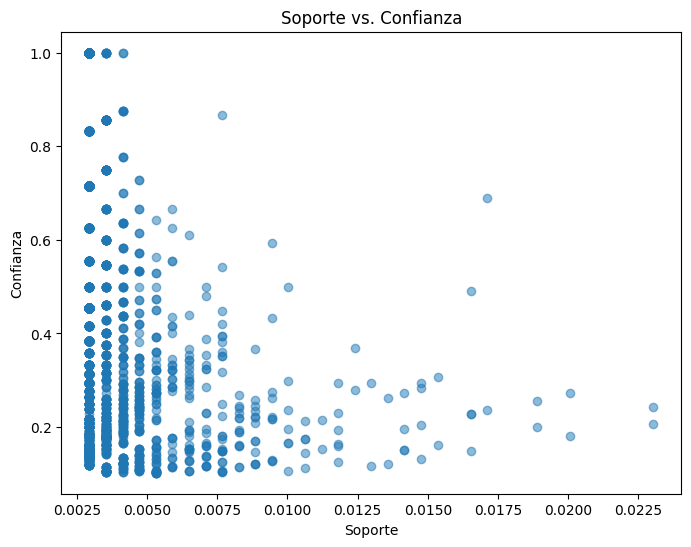

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(reglas['support'], reglas['confidence'], alpha=0.5)
plt.title('Soporte vs. Confianza')
plt.xlabel('Soporte')
plt.ylabel('Confianza')
plt.show()

In [15]:
# Visualizar soporte vs lift o confianza vs lift
reglas.nunique()


antecedents     668
consequents     530
support          27
confidence      274
lift           1011
dtype: int64